In [1]:
from astropy import units as u
from colorcet import cm
from eigenroutines import *
from gc import collect
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import lstsq as least_squares_fit
from os import mkdir, path
from pandas import DataFrame
import pickle
from parameter_functions import *
import starry
from system_properties import warm_Jupiter as system_properties
from warnings import filterwarnings

%matplotlib inline

starry.config.lazy = False
starry.config.quiet = True

filterwarnings("ignore", category=FutureWarning)

plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rc("axes", labelsize=19)
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

In [2]:
max_degree = 20
num_eigencurves = 50
# num_eigencurves = (max_degree+1)**2 - 1

In [3]:
time_extent = "T1-T4"
# Number of points per orbital period.
time_resolution = 12500

In [4]:
# preferred_colormap = cm["gray"]
#preferred_colormap = cm["linear_kryw_5_100_c67"]
preferred_colormap = cm["linear_worb_100_25_c53_r"]
saved_filetypes = ["pdf", "png"]
save_directory = "Plots/WJ/retrieval/oblLOS90".format(max_degree)
if not path.isdir(save_directory):
    mkdir(save_directory)

In [5]:
system = generate_system(system_properties, max_degree)
star = system.primary
planet = system.secondaries[0]

In [6]:
eclipse_timings = eclipse_durations(system)

In [7]:
print(eclipse_timings)

{'total': <Quantity 0.14131612 d>, 'full': <Quantity 0.09506685 d>, 'ingress': <Quantity 0.02312463 d>, 'egress': <Quantity 0.02312463 d>}


In [8]:
rotation_scale = rotation_parameter(system, timescale="ingress")
rotation_scale_total = rotation_parameter(system, timescale="total")
print(rotation_scale)
print(rotation_scale_total)
print(rotation_scale/rotation_scale_total)

print(time_resolution/rotation_scale)

432.43932102628816
70.76333727020413
6.111064538619106
28.90578953443533


In [9]:
rotation_ratios = np.r_[np.array([1e-4, 1]), np.logspace(-7, 6, num=14, base=2)*rotation_scale]
parameter_values = rotation_ratios
function_to_vary_parameter = vary_rotation_rate_ratio

In [10]:
times = cut_to_eclipse(system=system,
                       time_resolution=time_resolution,
                       extent=time_extent)

In [11]:
save_name = system_properties["name"] + ".2021-01-26_rotrate_50-curves_deg20"

In [12]:
try:
    mode_sets = pickle.load(open(save_name+".p", "rb"))

except:
    print("Didn't find the mode sets! Generating...")
    mode_sets = generate_set_of_eigenmodes(system=system,
                                           times=times,
                                           function_to_vary_parameter=function_to_vary_parameter,
                                           parameter_values=parameter_values,
                                           max_degree=max_degree,
                                           num_eigencurves=num_eigencurves)

    if save_name is not None:
        pickle.dump(mode_sets, open(save_name+".p", "wb"))

In [13]:
component_sets = mode_sets["component sets"]
constant_curves = mode_sets["constant curves"]
harmonic_sets = mode_sets["harmonic sets"]
score_sets = mode_sets["score sets"]
fixed_labels = mode_sets["fixed labels"]
variable_labels = mode_sets["variable labels"]

In [14]:
eigencurve_sets = []
for component_set, constant_curve, harmonic_set in zip(component_sets, constant_curves, harmonic_sets):
    eigencurves = [constant_curve]
    for component in component_set:
        eigencurve = np.sum(component*harmonic_set, axis=1)
        eigencurves.append(eigencurve)
    eigencurves = np.asarray(eigencurves).T
    eigencurve_sets.append(eigencurves)

In [15]:
test_properties = system_properties.copy()
# Our base is the zero obliquity, synchronous case.
test_oblLOS = 90
test_properties["secondary map"]["inc"] = 90 - test_oblLOS
# test_rotation_period = planet.porb / rotation_scale
test_rotation_period = planet.porb
test_properties["secondary"]["prot"] = test_rotation_period

test_system = generate_system(test_properties)

In [16]:
observed_hotspot_latitude = 45*u.deg
hotspot_latitude = observed_hotspot_latitude + test_oblLOS*u.deg
hotspot_longitude = 45*u.deg
hotspot_size = 5*u.deg

In [17]:
rotation_ratios = np.r_[np.array([1e-4, 1]), np.logspace(-7, 6, num=14, base=2)*rotation_scale]
parameter_values = rotation_ratios
function_to_vary_parameter = vary_rotation_rate_ratio

In [18]:
test_sets = generate_set_of_test_planets(system=test_system,
                                         times=times,
                                         function_to_vary_parameter=function_to_vary_parameter,
                                         parameter_values=parameter_values,
                                         latitude=hotspot_latitude,
                                         longitude_offset=hotspot_longitude,
                                         angular_size=hotspot_size)

In [19]:
test_maps = test_sets["maps"]
test_curves = test_sets["light curves"]

In [20]:
synchronous_eigencurves = eigencurve_sets[1]
synchronous_components = component_sets[1]

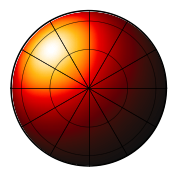

In [21]:
fig, ax = plt.subplots(figsize=(6, 3))
test_maps[0].show(ax=ax, theta=0, cmap=cm["linear_kryw_5_100_c67"], grid=True, projection="ortho")
for filetype in saved_filetypes:
    plt.savefig(save_directory + "/" + system_properties["name"] +\
                "_" + "input-map_lat{:.0f}_lon{:.0f}_size{:.0f}_{:.2f}.{}".format(hotspot_latitude.to(u.deg).value,
                                                                                  hotspot_longitude.to(u.deg).value,
                                                                                  hotspot_size.to(u.deg).value,
                                                                                  test_rotation_period,
                                                                                  filetype),
                bbox_inches="tight", dpi=300)

In [22]:
# cutoff_curve = np.shape(component_sets)[1] + 1
cutoff_curve = 10 + 1
fit_curves = [least_squares_fit(synchronous_eigencurves[..., :cutoff_curve], test_curve)[0]
              for test_curve in test_curves]

In [23]:
coefficient_sets = []
residual_sets = []
for test_curve in test_curves:
    coefficients = []
    residuals = []
    for i in range(2, np.shape(synchronous_eigencurves)[-1]+1):
        fit_coefficients, fit_residual, _, _ = least_squares_fit(synchronous_eigencurves[..., :i], test_curve)
        coefficients.append(fit_coefficients)
        residuals.append(fit_residual.squeeze())
    coefficient_sets.append(coefficients)
    residual_sets.append(residuals)

residual_sets = np.asarray(residual_sets)

In [24]:
test_curve_amplitude_squared = np.sum(test_curve)**2
fractional_residuals = np.sqrt(residual_sets / test_curve_amplitude_squared)
tolerance = 2e-2
num_needed_eigencurves = np.sum(fractional_residuals>=tolerance, axis=-1)
print(num_needed_eigencurves)

[ 1  1  1  1  0  0  1  0  2  3  7 14 38 50  9 21]


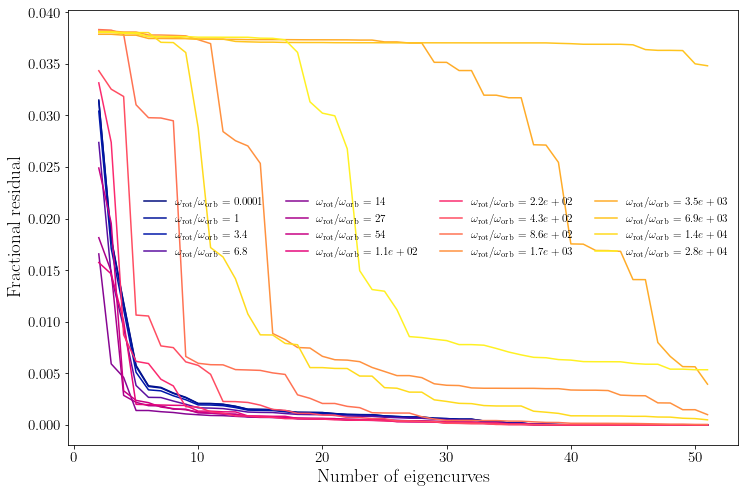

In [25]:
residual_colormap = cm["bmy"]
colors = [residual_colormap(value) for value in np.linspace(0, 1, num=len(variable_labels))]
fig, ax = plt.subplots(figsize=(12, 8))
for i, (fractional_residual, variable_label, color) in enumerate(zip(fractional_residuals, variable_labels, colors)):
    if i == 9:
        ax.plot(np.arange(2, len(fractional_residual)+2), fractional_residual, label=variable_label, color=color)
    else:
        ax.plot(np.arange(2, len(fractional_residual)+2), fractional_residual, label=variable_label, color=color)
ax.legend(ncol=4, fontsize=11, frameon=False)
ax.set_xlabel("Number of eigencurves")
ax.set_ylabel("Fractional residual")
# ax.axhline(tolerance, linestyle="dashed", linewidth=2, color="#444444", zorder=-1)

for filetype in saved_filetypes:
    plt.savefig(save_directory + "/" + system_properties["name"] +\
                "_" + "residuals_lat{:.0f}_lon{:.0f}_size{:.0f}_{:.2f}.{}".format(hotspot_latitude.to(u.deg).value,
                                                                                  hotspot_longitude.to(u.deg).value,
                                                                                  hotspot_size.to(u.deg).value,
                                                                                  test_rotation_period,
                                                                                  filetype),
                bbox_inches="tight", dpi=300)

In [26]:
'''
fig, ax = plt.subplots(figsize=(8, 6))
for variable_label, fit_curve in zip(variable_labels, fit_curves):
    ax.plot(fit_curve[0], label=variable_label)
plt.legend()
'''

'\nfig, ax = plt.subplots(figsize=(8, 6))\nfor variable_label, fit_curve in zip(variable_labels, fit_curves):\n    ax.plot(fit_curve[0], label=variable_label)\nplt.legend()\n'

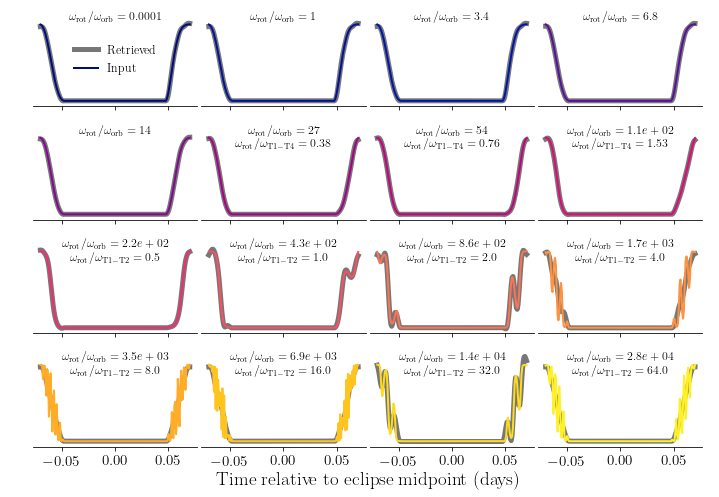

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8), sharex=True, sharey=True)

# bg_colors = [cm["dimgray_r"](value) for value in np.linspace(0, 1, num=len(variable_labels))]

for i, (ax,
        fit_curve,
        test_curve,
        rotation_ratio,
        variable_label,
        color) in enumerate(zip(axes.flatten(),
                                fit_curves,
                                test_curves,
                                rotation_ratios,
                                variable_labels,
                                colors)):
    ax.plot(times, np.sum(fit_curve*synchronous_eigencurves[..., :cutoff_curve], axis=1), label="Retrieved", linewidth=5, c="#777777")
    ax.plot(times, test_curve, label="Input", c=color, linewidth=2)
    full_title = variable_label
    if rotation_ratio/rotation_scale_total >= 0.25 and rotation_ratio/rotation_scale <= 0.25:
        full_title = full_title + "\n" + r"$\omega_\mathrm{{rot}}/\omega_\mathrm{{T1-T4}}={:.2f}$".format(rotation_ratio/rotation_scale_total)
    elif rotation_ratio/rotation_scale >= 0.25:
        full_title = full_title + "\n" + r"$\omega_\mathrm{{rot}}/\omega_\mathrm{{T1-T2}}={:.1f}$".format(rotation_ratio/rotation_scale)
    full_title = full_title.replace("\\\\", "\\")
    ax.set_title(full_title,
                 fontsize=12,
                 y=0.95,
                 verticalalignment="top")
    
    ax.yaxis.set_visible(False)
    if i == 0:
        ax.legend(frameon=False, fontsize=12, loc="center")
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(hspace=0.2, wspace=0.025)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                top=False, bottom=False,
                left=False, right=False)
plt.xlabel(r"Time relative to eclipse midpoint (days)")
for filetype in saved_filetypes:
    plt.savefig(save_directory + "/" + system_properties["name"] +\
                    "_" + "retrieved_curves_lat{:.0f}_lon{:.0f}_{}-curves_{:.2f}.{}".format(hotspot_latitude.to(u.deg).value,
                                                                                            hotspot_longitude.to(u.deg).value,
                                                                                            cutoff_curve,
                                                                                            test_rotation_period,
                                                                                            filetype),
                bbox_inches="tight", dpi=300)

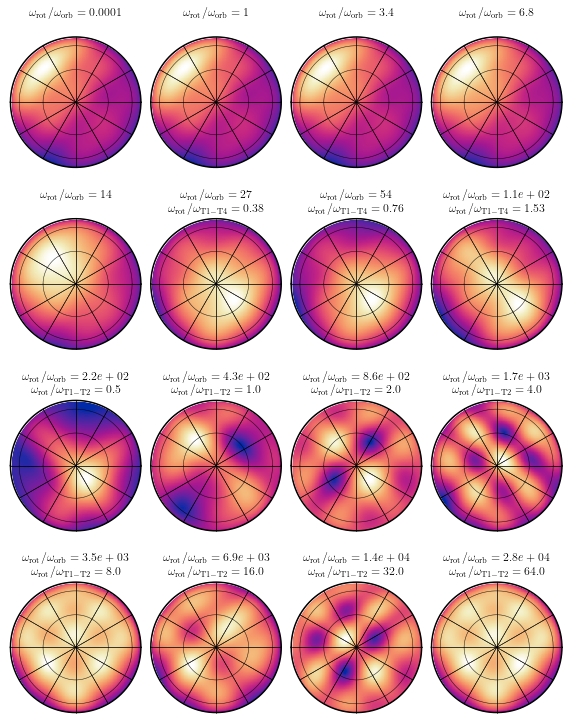

In [28]:
plt.clf()
plt.close("all")
collect(2)
fig, axes = plt.subplots(4, 4, figsize=(10, 13), sharex=True, sharey=True)
for ax, fit_curve, variable_label, rotation_ratio, color in zip(axes.flatten(),
                                                                fit_curves,
                                                                variable_labels,
                                                                rotation_ratios,
                                                                colors):
    retrieved_components = np.r_[1, np.sum(fit_curve[1:]*synchronous_components[:cutoff_curve-1].T, axis=-1)]
    retrieved_map = starry.Map(ydeg=max_degree)
    retrieved_map.inc = 90 - test_oblLOS
    for l in range(1, max_degree+1):
        for m in range(-l, l+1):
            retrieved_map[l, m] = retrieved_components[l**2+l+m]
    retrieved_map.rotate([-1, 0, 0], test_oblLOS)
    retrieved_map.show(ax=ax, cmap=preferred_colormap, theta=0, grid=True, projection="ortho")
    # ax.set_facecolor(color)
    # ax.outline_patch.set_edgecolor(color)
    #map_render = retrieved_map.render(projection="mollweide", theta=0)
    #ax.imshow(map_render, aspect=0.5, cmap=preferred_colormap, origin="lower")
    #ax.axis("off")
    #ax.set_title(variable_label, fontsize=12)
    full_title = variable_label
    if rotation_ratio/rotation_scale_total >= 0.25 and rotation_ratio/rotation_scale <= 0.25:
        full_title = full_title + "\n" + r"$\omega_\mathrm{{rot}}/\omega_\mathrm{{T1-T4}}={:.2f}$".format(rotation_ratio/rotation_scale_total)
    elif rotation_ratio/rotation_scale >= 0.25:
        full_title = full_title + "\n" + r"$\omega_\mathrm{{rot}}/\omega_\mathrm{{T1-T2}}={:.1f}$".format(rotation_ratio/rotation_scale)
    full_title = full_title.replace("\\\\", "\\")
    ax.set_title(full_title,
                 fontsize=12,
                 y=1.15,
                 verticalalignment="top")

# axes.flatten()[-1].axis("off")
plt.subplots_adjust(hspace=0.125, wspace=0.025)
for filetype in saved_filetypes:
    plt.savefig(save_directory + "/" + system_properties["name"] +\
                "_" + "retrieved-maps_lat{:.0f}_lon{:.0f}_size{:.0f}_{:.2f}_{}-curves.{}".format(hotspot_latitude.to(u.deg).value,
                                                                                          hotspot_longitude.to(u.deg).value,
                                                                                          hotspot_size.to(u.deg).value,
                                                                                          test_rotation_period,
                                                                                          cutoff_curve,
                                                                                          filetype),
                bbox_inches="tight", dpi=300)